## KarpovCourses. Продуктовая аналитика 
### Сегментация клиентов в Python 
 
### RFM-анализ

In [1]:
import pandas as pd
import numpy as np


# Matplotlib forms basis for visualization in Python
import matplotlib.pyplot as plt

# We will use the Seaborn library
import seaborn as sns
sns.set()

# Graphics in SVG format are more sharp and legible
# get_ipython().run_line_magic('config', "InlineBackend.figure_format = 'svg'")

# Increase the default plot size and set the color scheme
plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['image.cmap'] = 'viridis'

In [32]:
orders = pd.read_csv(r'C:\Users\Oleg Savkin\Projects\Карпов DA\Module_08_Экономика_продукта\Lesson_04_Сегментация\data\rfm_data.csv',
                     sep=',')
orders

,order_date,order_id,customer,grand_total
0,9/7/11,CA-2011-100006,Dennis Kane,378
1,7/8/11,CA-2011-100090,Ed Braxton,699
2,3/14/11,CA-2011-100293,Neil Franz�sisch,91
3,1/29/11,CA-2011-100328,Jasper Cacioppo,4
4,4/8/11,CA-2011-100363,Jim Mitchum,21
...,...,...,...,...
5004,11/4/14,US-2014-168802,Jack O'Briant,18
5005,7/24/14,US-2014-169320,Lena Hernandez,171
5006,9/8/14,US-2014-169488,Allen Armold,57
5007,8/29/14,US-2014-169502,Matthew Grinstein,113


In [37]:
orders.dtypes

order_date     datetime64[ns]
order_id               object
customer               object
grand_total             int64
dtype: object

In [36]:
orders.order_date = pd.to_datetime(orders.order_date)
orders['order_id'] = orders['order_id'].apply(str)
orders['customer'] = orders['customer'].apply(str)

In [41]:
last_date = orders.order_date.max()
last_date

Timestamp('2014-12-31 00:00:00')

In [42]:
rfmTable = orders \
                .groupby('customer') \
                .agg({'order_date': lambda x: (last_date - x.max()).days, #Recency #Количество дней с последнего заказа
                      'order_id': lambda x: len(x),                       # Frequency #Количество заказов
                      'grand_total': lambda x: x.sum()})                  # Monetary Value #Общая сумма по всем заказам

rfmTable['order_date'] = rfmTable['order_date'].astype(int)

rfmTable.rename(columns={'order_date': 'recency', 
                         'order_id' : 'frequency', 
                         'grand_total' : 'monetary_value'}, inplace=True)

In [43]:
rfmTable

,recency,frequency,monetary_value
customer,,,
Aaron Bergman,415,3,887
Aaron Hawkins,12,7,1744
Aaron Smayling,88,7,3050
Adam Bellavance,54,8,7756
Adam Hart,34,10,3249
...,...,...,...
Xylona Preis,43,11,2375
Yana Sorensen,9,8,6721
Yoseph Carroll,4,5,5455


In [44]:
rfmTable.shape[0], orders.customer.nunique()

(793, 793)

In [46]:
quantiles = rfmTable.quantile(q=[0.25,0.5,0.75])
quantiles

,recency,frequency,monetary_value
0.25,30.0,5.0,1145.0
0.50,75.0,6.0,2257.0
0.75,183.0,8.0,3784.0


In [47]:
rfmSegmentation = rfmTable

In [48]:

def RClass(value,parameter_name,quantiles_table):
    if value <= quantiles_table[parameter_name][0.25]:
        return 1
    elif value <= quantiles_table[parameter_name][0.50]:
        return 2
    elif value <= quantiles_table[parameter_name][0.75]: 
        return 3
    else:
        return 4


def FMClass(value, parameter_name,quantiles_table):
    if value <= quantiles_table[parameter_name][0.25]:
        return 4
    elif value <= quantiles_table[parameter_name][0.50]:
        return 3
    elif value <= quantiles_table[parameter_name][0.75]: 
        return 2
    else:
        return 1

In [49]:

rfmSegmentation['R_Quartile'] = rfmSegmentation['recency'].apply(RClass, args=('recency', quantiles))

rfmSegmentation['F_Quartile'] = rfmSegmentation['frequency'].apply(FMClass, args=('frequency', quantiles))

rfmSegmentation['M_Quartile'] = rfmSegmentation['monetary_value'].apply(FMClass, args=('monetary_value', quantiles))

rfmSegmentation['RFMClass'] = rfmSegmentation.R_Quartile.map(str) \
                            + rfmSegmentation.F_Quartile.map(str) \
                            + rfmSegmentation.M_Quartile.map(str)

In [51]:
rfmSegmentation.head()

,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass
customer,,,,,,,
Aaron Bergman,415,3,887,4,4,4,444
Aaron Hawkins,12,7,1744,1,2,3,123
Aaron Smayling,88,7,3050,3,2,2,322
Adam Bellavance,54,8,7756,2,2,1,221
Adam Hart,34,10,3249,2,1,2,212


In [52]:
pd.crosstab(index = rfmSegmentation.R_Quartile, columns = rfmSegmentation.F_Quartile)

F_Quartile,1,2,3,4
R_Quartile,,,,
1,58,65,24,56
2,45,56,27,66
3,39,58,30,73
4,17,19,26,134


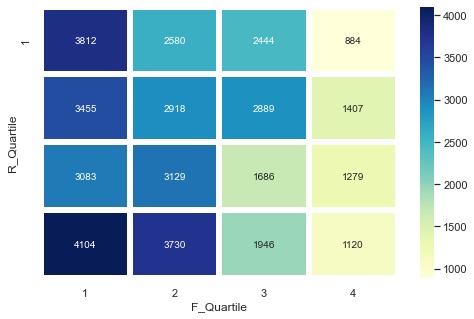

In [53]:
viz = rfmSegmentation.pivot_table(
                        index='R_Quartile', 
                        columns='F_Quartile', 
                        values='monetary_value', 
                        aggfunc=np.median).applymap(int)
sns.heatmap(viz, cmap="YlGnBu", annot=True, fmt=".0f", linewidths=4.15, annot_kws={"size": 10},yticklabels=4);